## FedeNET

----

#### Goal:
Develop a custom CNN for **binary classification (flip vs notflip)** that is efficient, task-focused, and original, integrating **frequency sensitivity** directly at the input level instead of relying solely on deeper convolutional layers to capture it.

The design is inspired by the **brightness and blur analysis** (via Laplacian Variance Map) performed on the dataset, where *flip* images consistently showed higher blur and lower sharpness compared to *notflip* images.

FedeNET explicitly incorporates this insight by introducing fixed, precomputed frequency maps that help the model distinguish between motion-blurred and static frames more effectively.   


----


#### Imports and Environment

In [1]:
import os, random
from pathlib import Path
import numpy as np
import torch
import torchvision.transforms as tvT


In [2]:
import fedenet
from fedenet import __version__ as FEDE_VERSION
from fedenet.transforms import NormalizeRGBOnly, ResizePad, AppendFrequencyMaps


In [3]:
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


torch: 2.5.1+cu121
built with CUDA: 12.1
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [4]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Access the datasets
DATA_ROOT = Path("data") / "images"
splits = ["training", "testing"]
classes = ["flip", "notflip"]

for split in splits:
    for cls in classes:
        p = DATA_ROOT / split / cls
        assert p.is_dir(), f"Missing folder: {p}"
print("Folder structure looks OK.")

Folder structure looks OK.


----

### Step 1 - Precomputed Frequency Maps

This transform:
  - converts image to grayscale
  - computes fixed, zero-parameter frequency maps:
    - 1 Sobel gradient magnitude (edges)
    - 2 Laplacian magnitude (second-order structure / blur sensitivity)
    - 3 Local variance (texture / blur sensitivity, window=7)
    - 4- High-pass (unsharp) magnitude (fine detail energy)
  - robust-normalizes each map to [0,1]
  - concatenates maps to RGB => (3 + K, H, W)


In [5]:
import matplotlib.pyplot as plt

In [ ]:
def visualize_fede_grid4x4(
    x,
    freq_names=("Sobel", "Laplacian", "LocalVar", "HighPass"),
    figsize=(20, 16),
    bins=50
):
    """
    x: tensor of shape (3 + K, H, W) from AppendFrequencyMaps.
    Produces a 4×4 grid:
      Row1: Composite / R / G / B images
      Row2: Corresponding histograms (Composite average, R, G, B)
      Row3: Frequency maps images: Sobel / Laplacian / LocalVar / HighPass
      Row4: Corresponding histograms of the frequency maps
    """
    assert x.ndim == 3 and x.shape[0] >= 7, f"Expected at least 7 channels, got {x.shape[0]}"
    # Extract RGB and frequency
    rgb = x[:3].permute(1,2,0).cpu().numpy()           # (H, W, 3)
    freq = x[3:3+len(freq_names)].detach().cpu().numpy() # (K, H, W)
    H, W = rgb.shape[:2]
    K = freq.shape[0]
    assert K == 4, f"Expected 4 frequency maps, got {K}"
    
    # Prepare figure with 4 rows and 4 columns
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    max_y_axis_value = 30000
    
    # Row 1: images RGB composite + R/G/B
    axes[0,0].imshow(rgb)
    axes[0,0].set_title("Composite")
    axes[0,0].axis('off')
    for i, ch in enumerate([0,1,2], start=1):
        axes[0,i].imshow(rgb[:,:,ch], cmap='gray')
        axes[0,i].set_title(["R","G","B"][ch])
        axes[0,i].axis('off')
    
    # Row 2: histograms for Composite, R/G/B
    # Composite histogram: average across RGB channels
    composite_vals = rgb.reshape(-1,3).mean(axis=1)
    axes[1,0].hist(composite_vals, bins=bins, color='gray', alpha=0.7)
    axes[1,0].set_title("Composite hist")
    axes[1,0].set_xlabel("Value")
    # R/G/B hist
    for i, ch in enumerate([0,1,2], start=1):
        vals = rgb[:,:,ch].reshape(-1)
        axes[1,i].hist(vals, bins=bins, color=['r','g','b'][ch], alpha=0.7)
        axes[1,i].set_ylim(top=max_y_axis_value)
        axes[1,i].set_title(f"{['R','G','B'][ch]} hist")
        axes[1,i].set_xlabel("Value")
    
    # Row 3: freq map images
    for j, name in enumerate(freq_names):
        axes[2, j].imshow(freq[j,:,:], cmap='gray', vmin=0.0, vmax=1.0)
        axes[2, j].set_title(name)
        axes[2, j].axis('off')
    
    # Row 4: histograms of freq maps
    for j, name in enumerate(freq_names):
        vals = freq[j,:,:].reshape(-1)
        axes[3, j].hist(vals, bins=bins, color='black', alpha=0.7)
        axes[3, j].set_ylim(top=max_y_axis_value)
        axes[3, j].set_title(f"{name} hist")
        axes[3, j].set_xlabel("Value")
    
    plt.tight_layout()
    plt.show()



In [7]:
from torchvision.io import read_image
from PIL import Image

In [8]:
flip_img_path    = list((DATA_ROOT/"testing"/"flip").rglob("*.*"))[random.randint(0,10)]
notflip_img_path = list((DATA_ROOT/"testing"/"notflip").rglob("*.*"))[random.randint(0,10)]

In [9]:
print("Flip sample:",    flip_img_path)
print("NotFlip sample:", notflip_img_path)

Flip sample: data\images\testing\flip\0002_000000017.jpg
NotFlip sample: data\images\testing\notflip\0001_000000004.jpg


In [10]:
flip_img    = Image.open(flip_img_path).convert("RGB")
notflip_img = Image.open(notflip_img_path).convert("RGB")

In [11]:
TARGET_H, TARGET_W = 540, 960
FREQ_CHANNELS = ("sobel", "laplacian", "localvar", "highpass")

In [12]:
# Build minimal pipeline for visualization
vis_tfms = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.ToTensor(),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    # For visualization: keep frequency maps in [0,1] scale for direct interpretability
    # Note: In training mode we will apply NormalizeRGBOnly to the first 3 channels; we leave the freq‐channels as is.
])

In [13]:
flip_x    = vis_tfms(flip_img)
notflip_x = vis_tfms(notflip_img)

Flip:


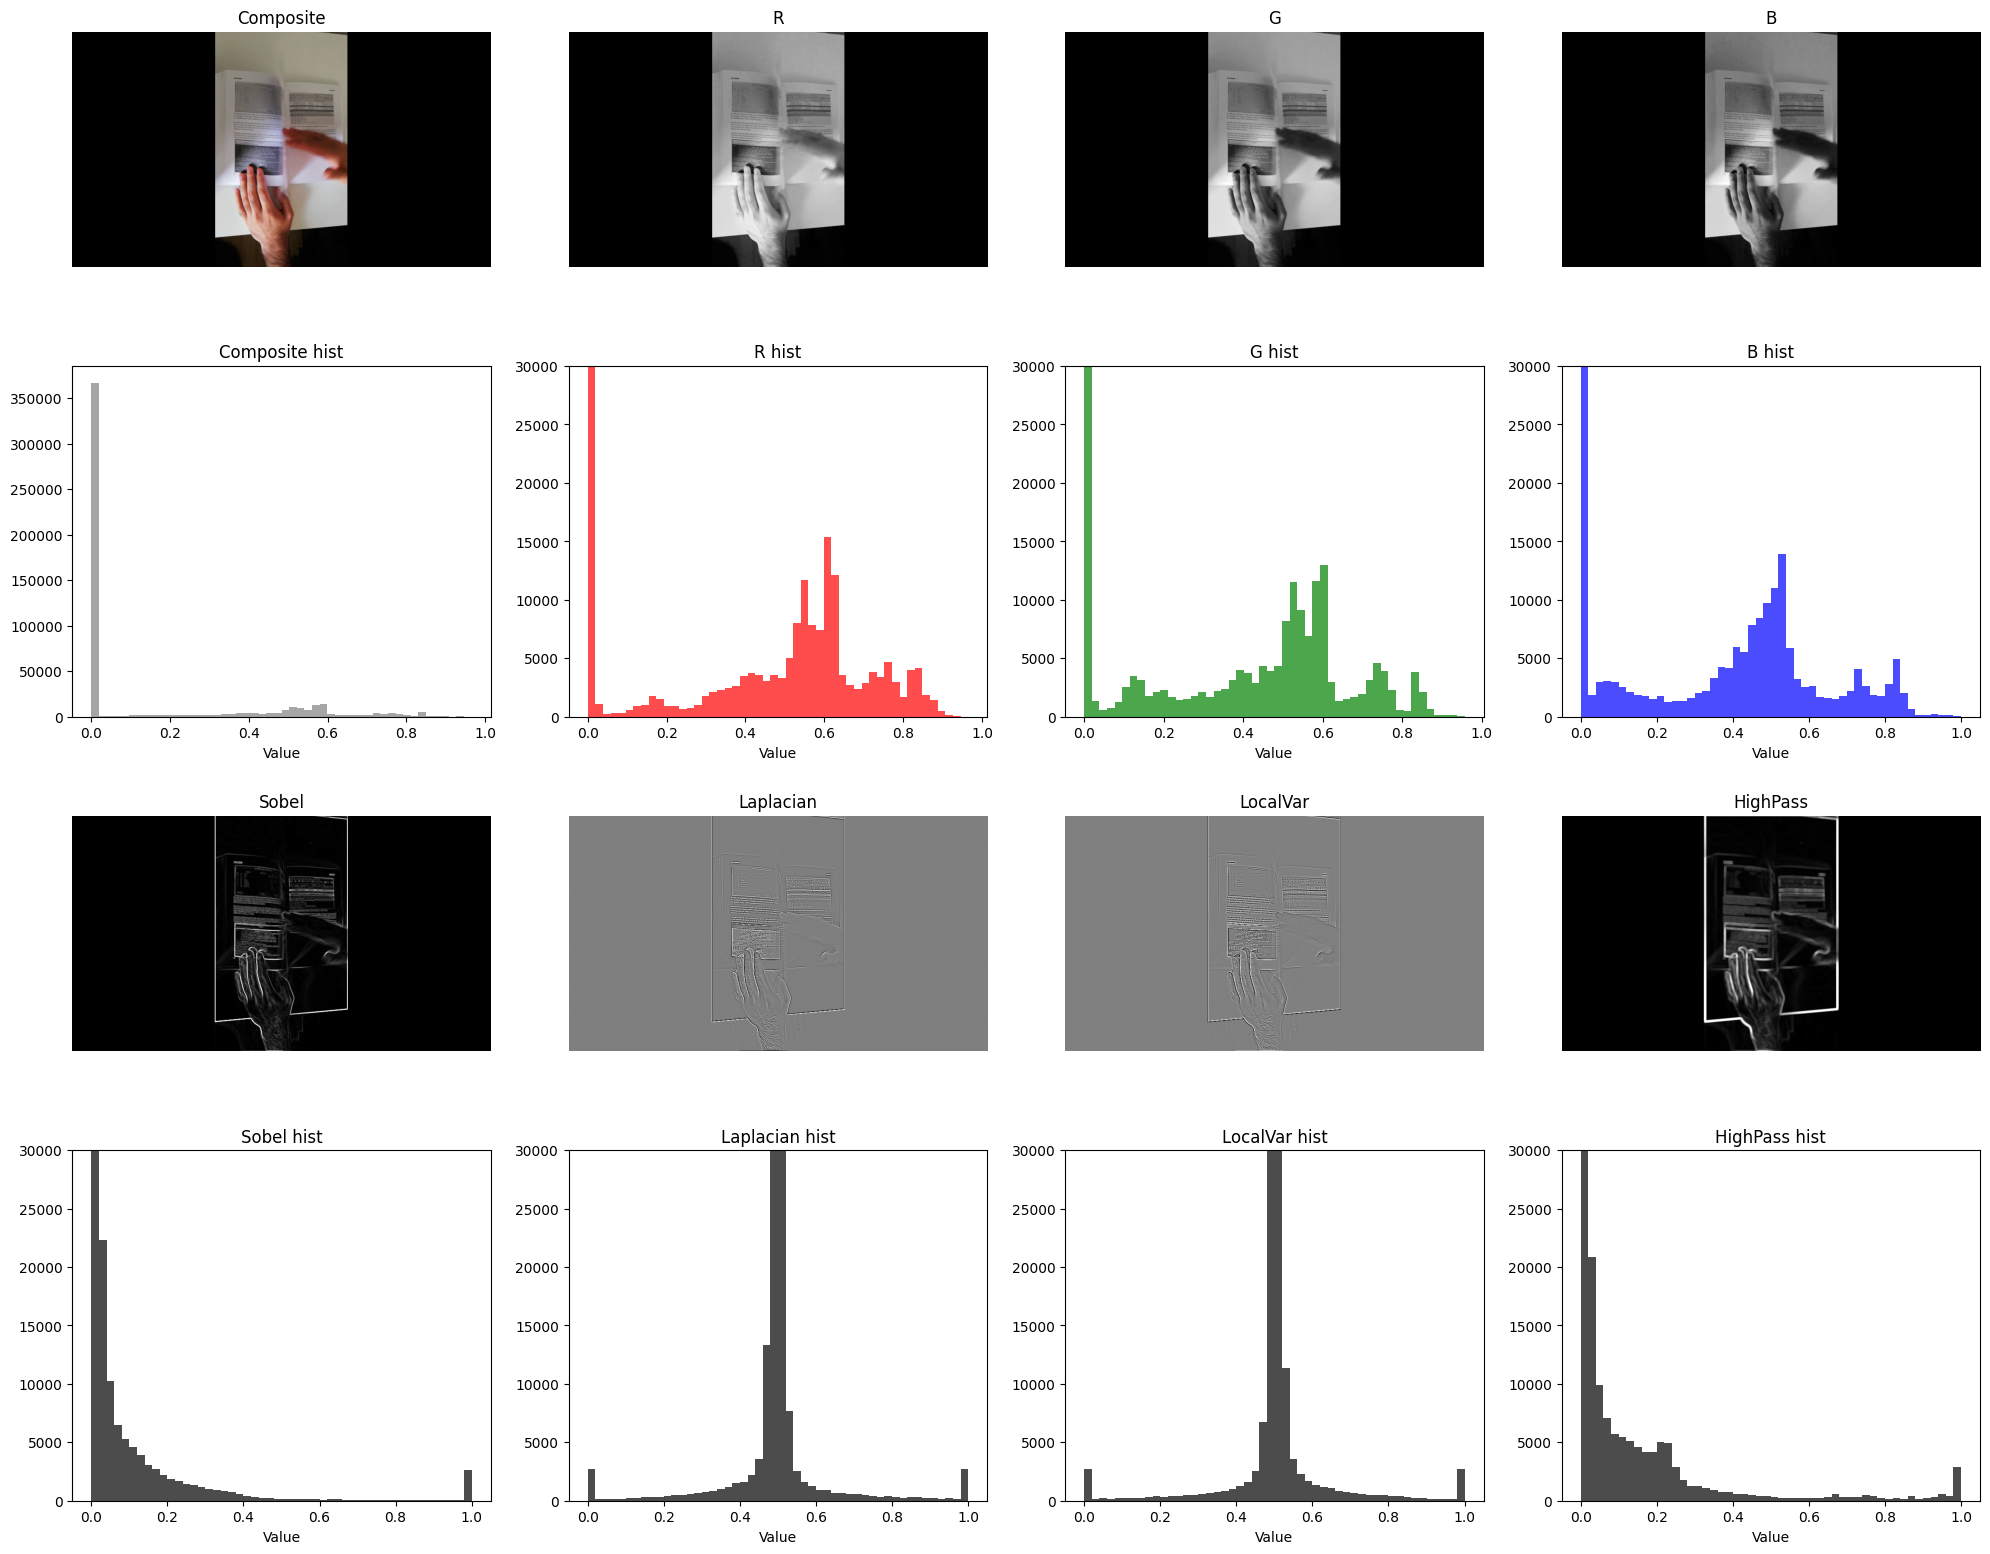

NotFlip:


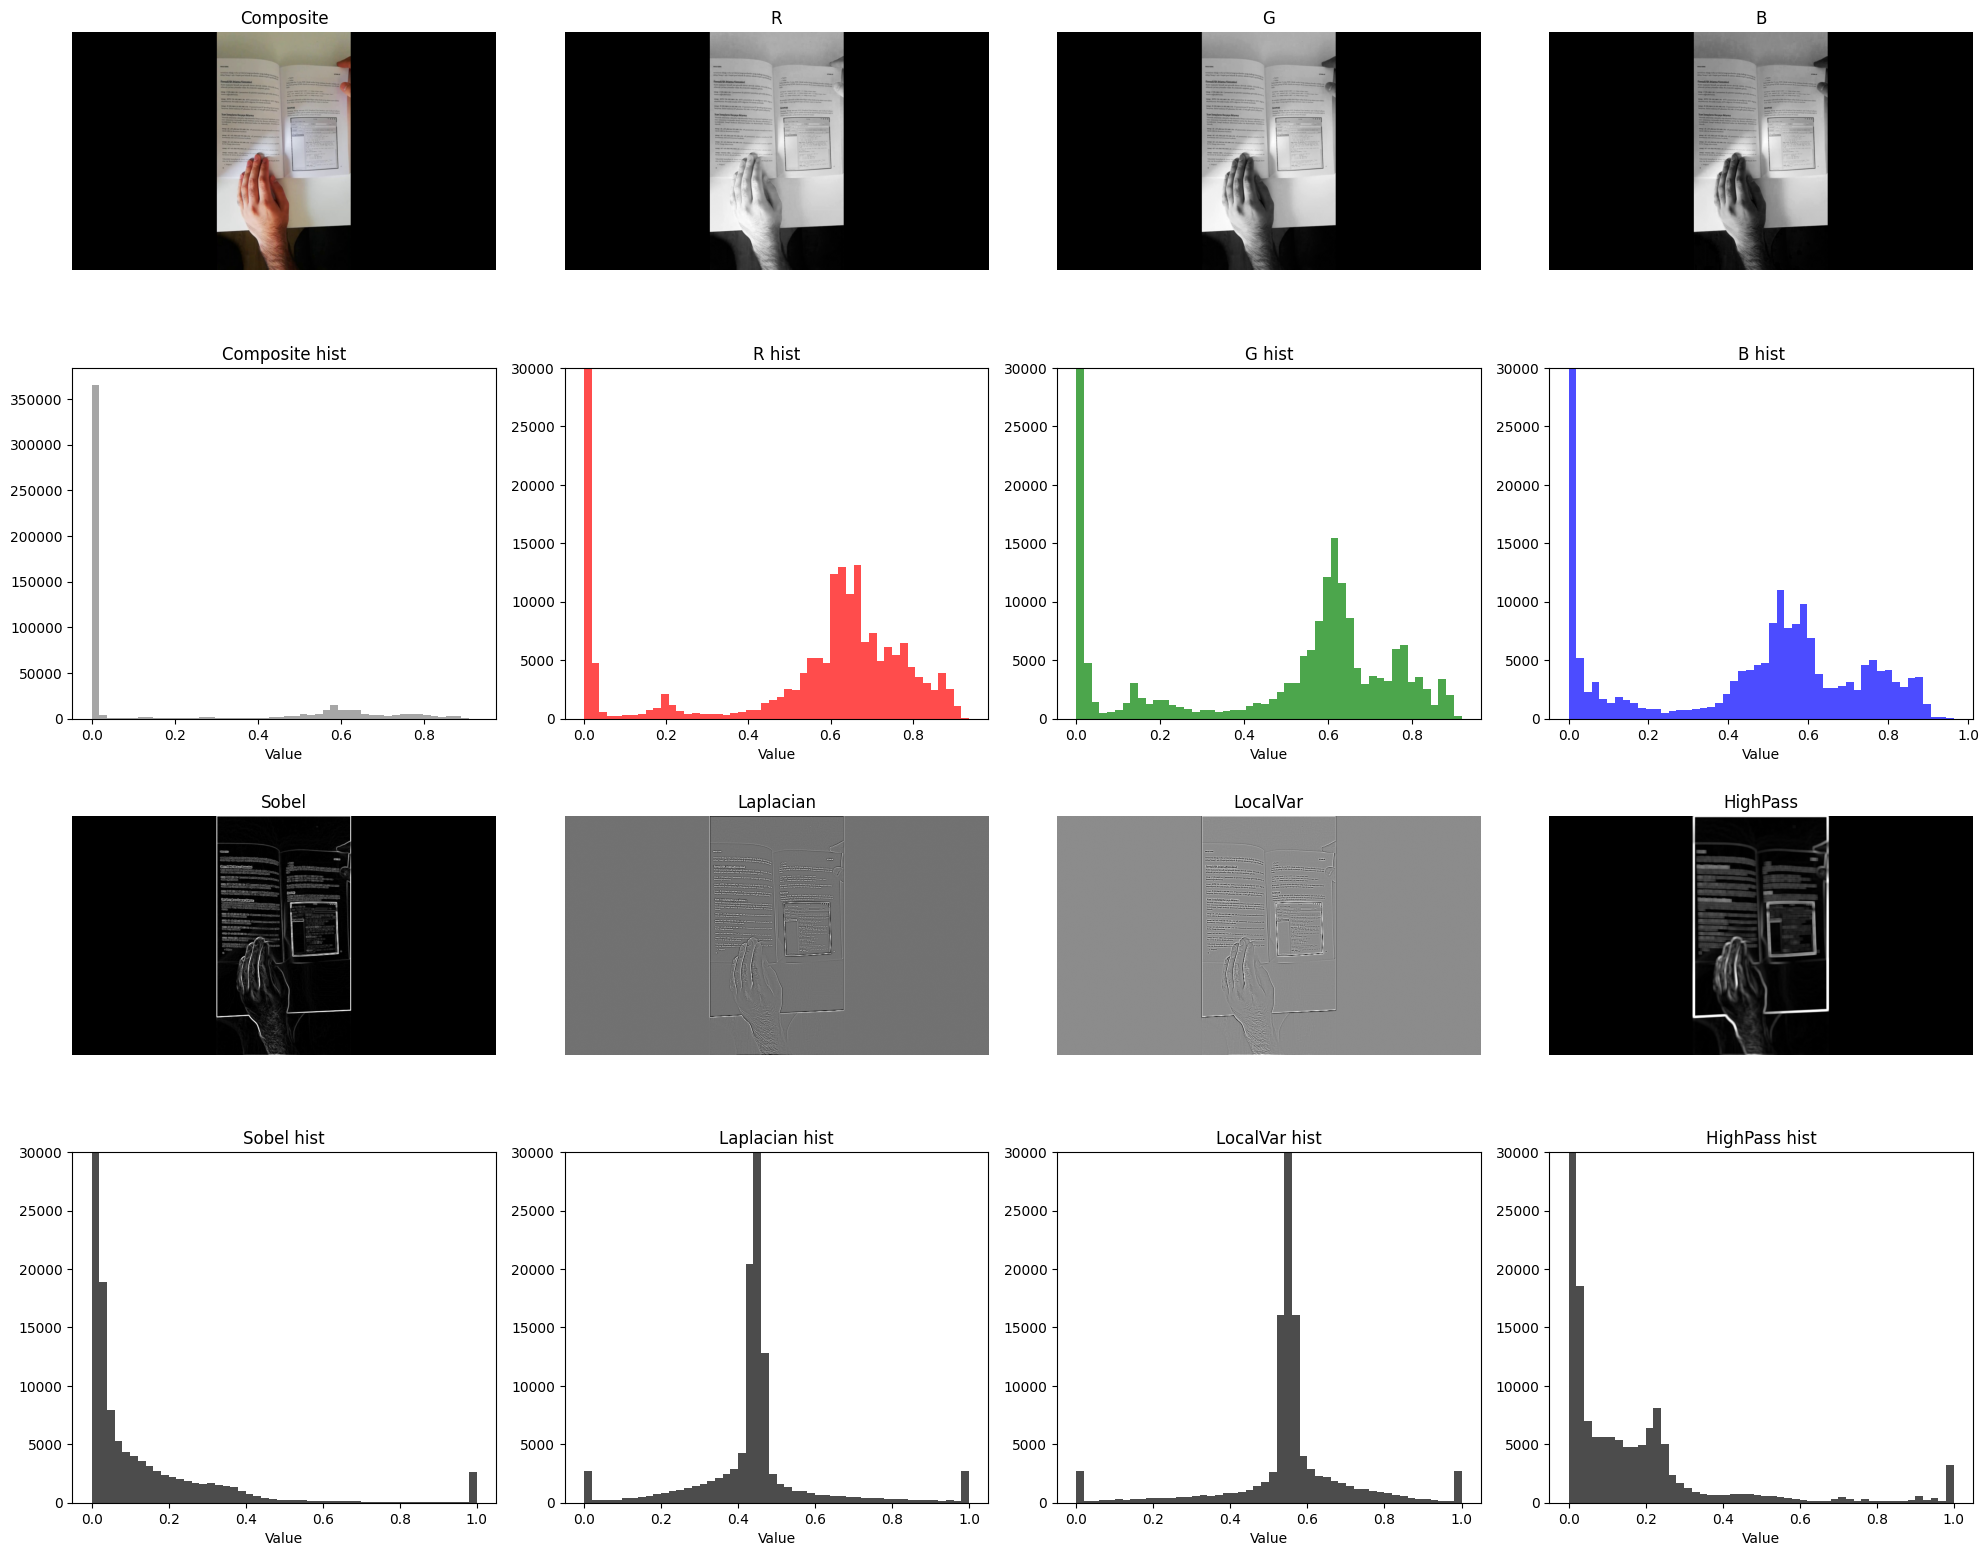

In [14]:
print("Flip:")
visualize_fede_grid4x4(flip_x)
print("NotFlip:")
visualize_fede_grid4x4(notflip_x)

Above we see two representative frames (flip / not-flip) with their corresponding histograms for the RGB channels and the four appended frequency maps (Sobel, Laplacian, LocalVar, HighPass).  

A few key observations:

- The **Sobel** and **HighPass** histograms show long tails towards high values: both filters emphasise rapid intensity changes (edges or fine detail), so many pixels map to low values (smooth regions) and a subset map to high values (sharp transitions).  
- The **Laplacian** and **LocalVar** histograms exhibit a strong peak in the central range with thin tails: the Laplacian (a second-order derivative) responds mainly to changes in the gradient, so most pixels (in flat or gradual regions) yield near-zero responses. Similarly, the LocalVar map (local variance) shows low values in smooth zones, with only textured or noisy patches producing higher responses.  
- Because each map is normalised (min-max or robust quantile → [0, 1]), the dominant “zero/low‐change” regions cluster near the low end, and only the strongest responses are scaled toward 1. This explains why the **Laplacian/LocalVar** histograms appear “centered” rather than dominated by high values.  

In short:  
  - **Sobel**, **HighPass** → first‐order and high‐frequency detail filters → more strong‐response pixels → heavier right‐tail in histogram.  
  - **Laplacian**, **LocalVar** → second‐order or local‐variance filters → many small/zero responses, fewer high responses → strong central peak.

This understanding aligns with the visual results and supports the choice of these maps as complementary features: Sobel/HighPass highlight abrupt structure; Laplacian/LocalVar characterise changes in structure and texture.



### Why adding the 4 frequency-channels improves flip vs not-flip classification  

Appending Sobel, Laplacian, LocalVar and HighPass channels to the original RGB input gives the CNN deeper structural cues beyond mere appearance. For example, Sobel and HighPass highlight first-order edges and fine detail (which are more likely in “not-flip” sharp frames), while Laplacian and LocalVar focus on gradient curvature and local texture uniformity (often lower in “flip” frames with motion/blur). As a result, the model can latch onto differences in edge clarity, label‐text sharpness and blur dynamics that are difficult to capture from RGB alone.  

In practice this results in a seven-channel input where the extra four channels act like engineered “feature maps” emphasising blur/texture/edge patterns. These give the network complementary, orthogonal information which helps reduce confusion caused by variations in lighting or colour. Therefore, the added frequency‐based channels can significantly boost the CNN’s ability to discriminate between flip and not-flip classes by exposing structural and textural degradations rather than relying solely on appearance.  


----

### Step 2 - Dataset and Dataloader setup

In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, random_split, DataLoader
from fedenet.transforms import IMAGENET_MEAN, IMAGENET_STD

In [16]:
# Base paths
TRAIN_DIR = DATA_ROOT / "training"
TEST_DIR  = DATA_ROOT / "testing"

In [17]:
# Train transform
train_tfms = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.RandomRotation(degrees=5, fill=0),
    tvT.ColorJitter(brightness=0.1, contrast=0.1),
    tvT.ToTensor(),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    NormalizeRGBOnly(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation transform
val_tfms = tvT.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    tvT.ToTensor(),
    AppendFrequencyMaps(maps=FREQ_CHANNELS),
    NormalizeRGBOnly(IMAGENET_MEAN, IMAGENET_STD),
])

In [18]:
full_train_ds = ImageFolder(root=TRAIN_DIR, transform=train_tfms)

# Compute the split sizes
val_ratio = 0.2
n_total = len(full_train_ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_ds, val_ds = random_split(full_train_ds, [n_train, n_val])

In [19]:
val_ds.dataset.transform = val_tfms

In [20]:
# DataLoaders for each set
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

test_ds = ImageFolder(root=TEST_DIR, transform=val_tfms)
test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

In [21]:
print("Classes:", train_ds.dataset.classes, train_ds.dataset.class_to_idx)
print("Length train:", len(train_ds), "   Length val:", len(val_ds), "   Length test:", len(test_ds))


Classes: ['flip', 'notflip'] {'flip': 0, 'notflip': 1}
Length train: 1914    Length val: 478    Length test: 597


----

### Step 3 - Model Steup

In [22]:
from fedenet.models import FedeNetTiny

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [24]:
# Instantiate model
model = FedeNetTiny(in_ch=7).to(device)

In [25]:
# Quick forward-sanity check with dummy input
dummy = torch.randn(1, 7, TARGET_H, TARGET_W, device=device)
with torch.no_grad():
    logits = model(dummy)
print("Output shape:", logits.shape)

Output shape: torch.Size([1, 1])


In [26]:
from torchinfo import summary

In [27]:
summary(model, input_size=(1,7, TARGET_H, TARGET_W), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
FedeNetTiny                                   [1, 7, 540, 960]          [1, 1]                    --                        --                        --
├─StemAA: 1-1                                 [1, 7, 540, 960]          [1, 32, 270, 480]         --                        --                        --
│    └─Conv2d: 2-1                            [1, 3, 540, 960]          [1, 32, 540, 960]         864                       [3, 3]                    447,897,600
│    └─Conv2d: 2-2                            [1, 4, 540, 960]          [1, 32, 540, 960]         1,152                     [3, 3]                    597,196,800
│    └─BatchNorm2d: 2-3                       [1, 32, 540, 960]         [1, 32, 540, 960]         64                        --                        64
│    └─SiLU: 2-4                              [1, 32, 540

----

### Step 4 - Training Loop Setup

In [28]:
#from lion_pytorch import lion
import torch.optim as optim
import torch.nn as nn
import time
from torch.amp import autocast, GradScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, average_precision_score

In [29]:
# Loss, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)

# Scale the loss/gradients using GradScaler to avoid underflow/overflow when training with mixed precision (FP16 on CUDA)
scaler = GradScaler()


In [82]:
def train_one_epoch(
    model,
    loader,
    device,
    optimizer,
    criterion,
    scaler,
    memory_format=torch.channels_last
):
    model.train()
    running_loss = 0.0
    total_samples = 0
    t_data = 0.0
    t_compute = 0.0

    for x, y in loader:
        t0 = time.time()
        x = x.to(device, non_blocking=True).to(memory_format=memory_format)
        y = y.to(device, non_blocking=True).float().view(-1, 1)
        t_data += time.time() - t0

        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        t_compute += time.time() - (t0 + t_data)

        batch_size = x.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = running_loss / max(total_samples, 1)
    print(f"[Timing] data={t_data:.1f}s  compute={t_compute:.1f}s")
    return avg_loss


In [83]:
# Loop parameters
epochs = 10  # adjust
best_f1 = -1.0
best_thr = 0.5

def _save_clean_ckpt(path, state_dict, epoch, best_f1, best_thr):
    torch.save(
        {
            "state_dict": state_dict,
            "epoch": int(epoch),
            "best_f1": float(best_f1),
            "best_thr": float(best_thr),
        },
        path,
    )

In [84]:
# Helper functions from the previous notebook
@torch.no_grad()
def infer_logits(model, loader, device):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()
        logits = model(x).squeeze(1)   # (B,)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    return torch.cat(all_logits).numpy(), torch.cat(all_targets).numpy()

def find_best_threshold_from_logits(logits, targets):
    # sweep in [0.05..0.95]
    probs = 1/(1+np.exp(-logits))
    thrs  = np.linspace(0.05, 0.95, 37)
    best  = (0.0, 0.5)  # f1, thr
    for t in thrs:
        preds = (probs >= t).astype(np.int64)
        p, r, f1, _ = precision_recall_fscore_support(targets, preds, average="binary", zero_division=0)
        if f1 > best[0]: best = (f1, t)
    return best[1], probs

def evaluate(model, loader, device, name="VAL", thr=None):
    logits, targets = infer_logits(model, loader, device)
    if thr is None:
        thr, probs = find_best_threshold_from_logits(logits, targets)
    else:
        probs = 1/(1+np.exp(-logits))

    preds = (probs >= thr).astype(np.int64)
    p, r, f1, _ = precision_recall_fscore_support(targets, preds, average="binary", zero_division=0)
    cm = confusion_matrix(targets, preds, labels=[0,1])
    roc = roc_auc_score(targets, probs)
    pr  = average_precision_score(targets, probs)

    acc = (preds == targets).mean()
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp + 1e-9)

    print(f"{name} @ thr={thr:.3f} | Acc {acc:.3f} | F1 {f1:.3f} | Prec {p:.3f} | Rec {r:.3f} | Spec {spec:.3f} | ROC-AUC {roc:.3f} | PR-AUC {pr:.3f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return {"thr":thr,"acc":acc,"f1":f1,"prec":p,"rec":r,"spec":spec,"roc":roc,"pr":pr,"cm":cm}

In [33]:
CKPT_DIR  = Path("checkpoints")
CKPT_PATH = CKPT_DIR / "fedenetTiny_lib_best.pth"

In [51]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    criterion,
    scaler,
    epochs,
    checkpoint_dir,
    experiment_name="default",
    best_f1_init=-1.0
):
    
    # History containers
    history = {
    "epoch": [],
    "train_loss": [],
    "val_f1": [],
    "val_prec": [],
    "val_rec": [],
    "val_spec": [],
    "val_roc": [],
    "val_pr": [],
    "val_thr": [],
    "lr": [],
    "time_sec": [],
}
    
    best_f1 = best_f1_init
    for epoch in range(1, epochs+1):
        start_time = time.time()
        train_loss = train_one_epoch(model, train_loader, device,
                                     optimizer, criterion, scaler)

        # Evaluate on validation set (assume evaluate returns a dict with metrics)
        stats = evaluate(model, val_loader, device)
        f1 = float(stats["f1"])
        thr = float(stats["thr"])

        if f1 > best_f1:
            best_f1 = f1
            torch.save(
                {"state_dict": model.state_dict(),
                 "epoch": epoch,
                 "best_f1": best_f1,
                 "best_thr": thr},
                checkpoint_dir / f"{experiment_name}_best_epoch_{epoch}.pth"
            )
            print(f"New best model saved at epoch {epoch} (F1={best_f1:.3f}, thr={thr:.3f})")
            
        # handle both kinds of schedulers
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(f1)   
        else:
            scheduler.step()
        
        lr_now = optimizer.param_groups[0]["lr"]
        time_elapsed = time.time() - start_time
        print(f"[Epoch {epoch:02d}] train_loss={train_loss:.4f}  val_f1={f1:.3f}  lr={lr_now:.2e}  ({time_elapsed:.1f}s)")

        # Log history
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_f1"].append(f1)
        history["val_prec"].append(float(stats["prec"]))
        history["val_rec"].append(float(stats["rec"]))
        history["val_spec"].append(float(stats["spec"]))
        history["val_roc"].append(float(stats["roc"]))
        history["val_pr"].append(float(stats["pr"]))
        history["val_thr"].append(thr)
        history["lr"].append(lr_now)
        history["time_sec"].append(time_elapsed)

    return history

In [35]:
history_exp1 = train_model(
    model, 
    train_loader, 
    val_loader, 
    device, 
    optimizer, 
    scheduler, 
    criterion, 
    scaler, 
    epochs=10, 
    checkpoint_dir=Path("checkpoints"), 
    experiment_name="exp1", 
    best_f1_init=-1.0
    )

[Timing] data=0.2s  compute=105.8s
VAL @ thr=0.900 | Acc 0.862 | F1 0.873 | Prec 0.819 | Rec 0.934 | Spec 0.787 | ROC-AUC 0.918 | PR-AUC 0.896
Confusion matrix [[TN FP],[FN TP]]:
 [[185  50]
 [ 16 227]]
New best model saved at epoch 1 (F1=0.873, thr=0.900)
[Epoch 01] train_loss=0.4978  val_f1=0.873  lr=1.92e-03  (353.7s)
[Timing] data=0.1s  compute=129.6s
VAL @ thr=0.500 | Acc 0.492 | F1 0.000 | Prec 0.000 | Rec 0.000 | Spec 1.000 | ROC-AUC 0.820 | PR-AUC 0.791
Confusion matrix [[TN FP],[FN TP]]:
 [[235   0]
 [243   0]]
[Epoch 02] train_loss=0.4077  val_f1=0.000  lr=1.71e-03  (326.6s)
[Timing] data=0.1s  compute=130.8s
VAL @ thr=0.425 | Acc 0.877 | F1 0.885 | Prec 0.843 | Rec 0.930 | Spec 0.821 | ROC-AUC 0.941 | PR-AUC 0.928
Confusion matrix [[TN FP],[FN TP]]:
 [[193  42]
 [ 17 226]]
New best model saved at epoch 3 (F1=0.885, thr=0.425)
[Epoch 03] train_loss=0.4146  val_f1=0.885  lr=1.38e-03  (320.8s)
[Timing] data=0.1s  compute=129.4s
VAL @ thr=0.050 | Acc 0.642 | F1 0.471 | Prec 0.95

In [36]:
import pandas as pd
import json

In [37]:
# Save the training history
def save_training_history(history, file):
    hist_df = pd.DataFrame(history)
    hist_df.to_csv(CKPT_DIR / (file + ".csv"), index=False)
    with open(CKPT_DIR / (file + ".json"), "w") as f:
        json.dump(history, f, indent=2)
    print("Saved training history to:", (CKPT_DIR / (file + ".csv")).resolve())

In [38]:
save_training_history(history_exp1, file="training_history_exp1")

Saved training history to: E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\training_history_exp1.csv


In [39]:
def print_training_history(history, ckpt_dir="checkpoints"):
    """
    history: dict with lists, or pandas.DataFrame, or str/path to CSV saved earlier.
             Expected keys (use what exists): 
             epoch, train_loss, val_f1, val_prec, val_rec, val_spec, val_roc, val_pr, val_thr, lr
    """
    # normalize input to a DataFrame
    if isinstance(history, (str, Path)):
        hist_df = pd.read_csv(Path(ckpt_dir) / history)
    elif isinstance(history, dict):
        hist_df = pd.DataFrame(history)
    elif isinstance(history, pd.DataFrame):
        hist_df = history.copy()
    else:
        raise TypeError("history must be dict, DataFrame, or CSV path")

    if "epoch" not in hist_df:
        raise ValueError("history is missing 'epoch' column")

    epochs = hist_df["epoch"]

    # create 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)
    (ax1, ax2), (ax3, ax4) = axes

    # Top-left: Loss 
    if "train_loss" in hist_df:
        ax1.plot(epochs, hist_df["train_loss"], label="train_loss")
    if "val_loss" in hist_df:
        ax1.plot(epochs, hist_df["val_loss"], label="val_loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best")

    # Top-right: Validation metrics
    plotted_any = False
    if "val_f1" in hist_df:
        ax2.plot(epochs, hist_df["val_f1"], label="F1", linewidth=2)
        plotted_any = True
    if "val_prec" in hist_df:
        ax2.plot(epochs, hist_df["val_prec"], label="Precision", linestyle="--")
        plotted_any = True
    if "val_rec" in hist_df:
        ax2.plot(epochs, hist_df["val_rec"], label="Recall", linestyle=":")
        plotted_any = True
    if "val_spec" in hist_df:
        ax2.plot(epochs, hist_df["val_spec"], label="Specificity", linestyle="-.")
        plotted_any = True
    ax2.set_title("Validation metrics")
    ax2.grid(True, alpha=0.3)
    if plotted_any:
        ax2.legend(loc="best")

    # Bottom-left: AUCs (validation)
    auc_any = False
    if "val_roc" in hist_df:
        ax3.plot(epochs, hist_df["val_roc"], label="ROC-AUC")
        auc_any = True
    if "val_pr" in hist_df:
        ax3.plot(epochs, hist_df["val_pr"], label="PR-AUC")
        auc_any = True
    ax3.set_title("Validation AUCs")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("AUC")
    ax3.grid(True, alpha=0.3)
    if auc_any:
        ax3.legend(loc="lower right")

    # Bottom-right: Learning rate (primary) + Best threshold (secondary)
    if "lr" in hist_df:
        ax4.plot(epochs, hist_df["lr"], label="lr")
    ax4.set_title("Learning rate & best threshold")
    ax4.set_xlabel("Epoch")
    ax4.grid(True, alpha=0.3)
    lines_labels = []
    if "lr" in hist_df:
        lines_labels.append(("lr", ax4.lines[-1]))

    if "val_thr" in hist_df:
        ax4b = ax4.twinx()
        ax4b.plot(epochs, hist_df["val_thr"], marker="o", linestyle="none", label="best_thr")
        ax4b.set_ylabel("Threshold")
        lines_labels.append(("best_thr", ax4b.lines[-1]))
        # Combined legend
        labs = [ll[0] for ll in lines_labels]
        lines = [ll[1] for ll in lines_labels]
        ax4.legend(lines, labs, loc="best")
    else:
        ax4.legend(loc="best")

    fig.suptitle("Training History", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


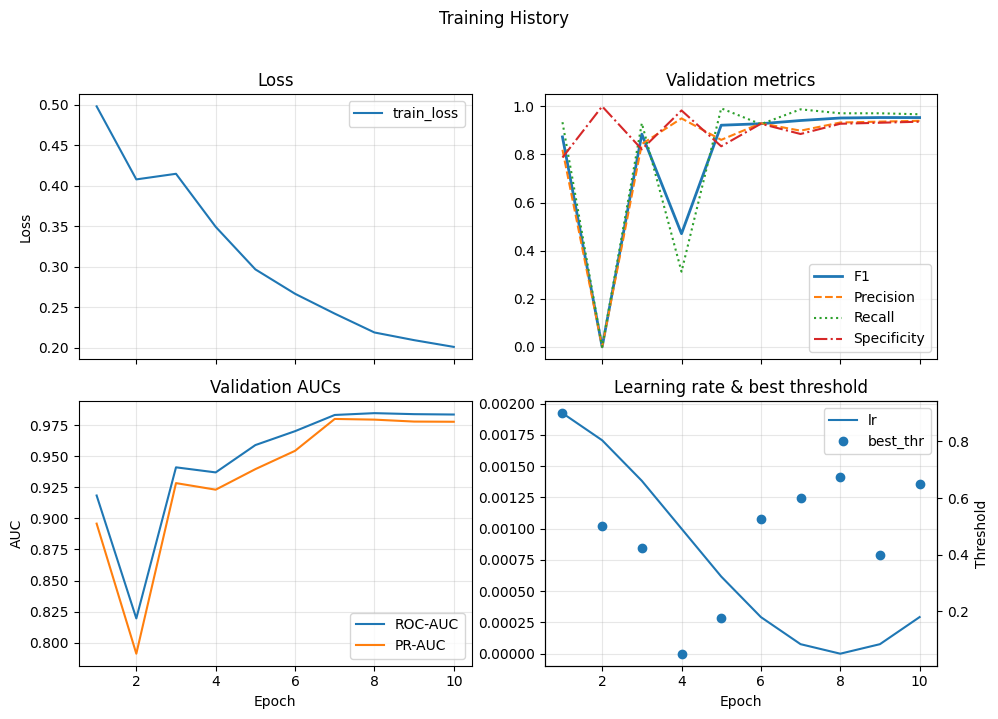

In [40]:
print_training_history(history_exp1)

In [86]:
@torch.no_grad()
def eval_with_threshold(model, loader, device, thr=0.5):
    model.eval()
    probs_all, tgts_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        probs_all.append(probs)
        tgts_all.append(labels.cpu().numpy())
    probs = np.concatenate(probs_all)
    tgts  = np.concatenate(tgts_all)

    preds = (probs >= thr).astype(int)

    acc  = accuracy_score(tgts, preds)
    prec = precision_score(tgts, preds, zero_division=0)
    rec  = recall_score(tgts, preds, zero_division=0)
    f1   = f1_score(tgts, preds, zero_division=0)
    cm   = confusion_matrix(tgts, preds)  # [[TN, FP], [FN, TP]]

    # threshold-free metrics for context
    roc_auc = roc_auc_score(tgts, probs)
    pr_auc  = average_precision_score(tgts, probs)

    # extra: specificity (TN rate)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / max(1, (tn + fp))

    return {
        "acc": acc, "precision": prec, "recall": rec, "f1": f1,
        "specificity": specificity, "roc_auc": roc_auc, "pr_auc": pr_auc, "cm": cm
    }

In [64]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve


In [110]:
# collect all the the predictions(as probs) and targets
@torch.no_grad()
def collect_val_probs_targets(model, loader, device):
    model.eval()
    probs_all, tgts_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()  # [B]
        probs_all.append(probs)
        tgts_all.append(labels.cpu().numpy())                   # [B]
    return np.concatenate(probs_all), np.concatenate(tgts_all)

def find_best_threshold_on_val(model, val_loader, device):
    
    # collect validation probabilities/targets
    val_probs, val_tgts = collect_val_probs_targets(model, val_loader, device)

    # sweep thresholds and pick the best by F1
    ths = np.linspace(0.0, 1.0, 1001)  # 0.001 step
    best = {"thr": 0.5, "f1": -1.0, "prec": 0.0, "rec": 0.0}
    for thr in ths:
        preds = (val_probs >= thr).astype(int)
        # handle edge cases gracefully (no positive predictions)
        f1   = f1_score(val_tgts, preds, zero_division=0)
        prec = precision_score(val_tgts, preds, zero_division=0)
        rec  = recall_score(val_tgts, preds, zero_division=0)
        if f1 > best["f1"]:
            best.update({"thr": float(thr), "f1": float(f1), "prec": float(prec), "rec": float(rec)})

    # print best threshold + confusion matrix at that threshold
    best_thr = best["thr"]
    best_preds = (val_probs >= best_thr).astype(int)
    cm = confusion_matrix(val_tgts, best_preds)

    print(f"Best VAL threshold for F1: {best_thr:.3f}")
    print(f"F1: {best['f1']:.3f} | Precision: {best['prec']:.3f} | Recall: {best['rec']:.3f}")
    print("Confusion matrix at best threshold [[TN, FP], [FN, TP]]:")
    print(cm)
    
    return best_thr

In [ ]:
best_thr = find_best_threshold_on_val(model, val_loader, device)

Best VAL threshold for F1: 0.614
F1: 0.954 | Precision: 0.937 | Recall: 0.971
Confusion matrix at best threshold [[TN, FP], [FN, TP]]:
[[219  16]
 [  7 236]]


In [69]:
test_metrics_exp1 = eval_with_threshold(model, test_loader, device, thr=best_thr)

def print_eval_results(test_metrics, best_thr): 
    print(f"Test @ thr={best_thr:.3f}")
    print(f"  Acc:  {test_metrics['acc']:.3f}")
    print(f"  F1:   {test_metrics['f1']:.3f}")
    print(f"  Prec: {test_metrics['precision']:.3f}")
    print(f"  Rec:  {test_metrics['recall']:.3f}")
    print(f"  Spec: {test_metrics['specificity']:.3f}")
    print(f"  ROC-AUC: {test_metrics['roc_auc']:.3f} | PR-AUC: {test_metrics['pr_auc']:.3f}")
    print("  Confusion matrix [[TN, FP], [FN, TP]]:")
    print(test_metrics["cm"])
    
print_eval_results(test_metrics_exp1, best_thr)

Test @ thr=0.614
  Acc:  0.933
  F1:   0.935
  Prec: 0.929
  Rec:  0.941
  Spec: 0.924
  ROC-AUC: 0.986 | PR-AUC: 0.986
  Confusion matrix [[TN, FP], [FN, TP]]:
[[268  22]
 [ 18 289]]


----

#### Experiment 2: Lion optimizer + CosineAnnealingLR scheduler

In [41]:
from lion_pytorch import Lion

In [42]:
# Instantiate a new model
model_exp2 = FedeNetTiny(in_ch=7).to(device)

optimizer_exp2 = Lion(
    model_exp2.parameters(),
    lr=1e-3,            # typically smaller than AdamW for Lion, per docs :contentReference[oaicite:1]{index=1}
    weight_decay=1e-3   # slightly stronger weight decay (as Lion updates differ) :contentReference[oaicite:2]{index=2}
)

In [43]:
scheduler_exp2 = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_exp2,
    T_max=8,            # same as before
    eta_min=0           
)

In [44]:
# call training loop using optimizer_exp1 & scheduler_exp1
history_exp2 = train_model(
    model=model_exp2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_exp2,
    scheduler=scheduler_exp2,
    criterion=criterion,
    scaler=scaler,
    epochs=10,
    checkpoint_dir=Path("checkpoints"),
    experiment_name="exp2",
    best_f1_init=-1.0
)

[Timing] data=0.1s  compute=126.3s
VAL @ thr=0.950 | Acc 0.856 | F1 0.868 | Prec 0.813 | Rec 0.930 | Spec 0.779 | ROC-AUC 0.932 | PR-AUC 0.921
Confusion matrix [[TN FP],[FN TP]]:
 [[183  52]
 [ 17 226]]
New best model saved at epoch 1 (F1=0.868, thr=0.950)
[Epoch 01] train_loss=0.5426  val_f1=0.868  lr=9.62e-04  (323.1s)
[Timing] data=0.1s  compute=127.0s
VAL @ thr=0.050 | Acc 0.845 | F1 0.853 | Prec 0.826 | Rec 0.881 | Spec 0.809 | ROC-AUC 0.914 | PR-AUC 0.882
Confusion matrix [[TN FP],[FN TP]]:
 [[190  45]
 [ 29 214]]
[Epoch 02] train_loss=0.4115  val_f1=0.853  lr=8.54e-04  (325.7s)
[Timing] data=0.0s  compute=128.9s
VAL @ thr=0.050 | Acc 0.603 | F1 0.375 | Prec 0.934 | Rec 0.235 | Spec 0.983 | ROC-AUC 0.920 | PR-AUC 0.908
Confusion matrix [[TN FP],[FN TP]]:
 [[231   4]
 [186  57]]
[Epoch 03] train_loss=0.3756  val_f1=0.375  lr=6.91e-04  (326.2s)
[Timing] data=0.1s  compute=126.2s
VAL @ thr=0.500 | Acc 0.887 | F1 0.897 | Prec 0.836 | Rec 0.967 | Spec 0.804 | ROC-AUC 0.948 | PR-AUC 0.

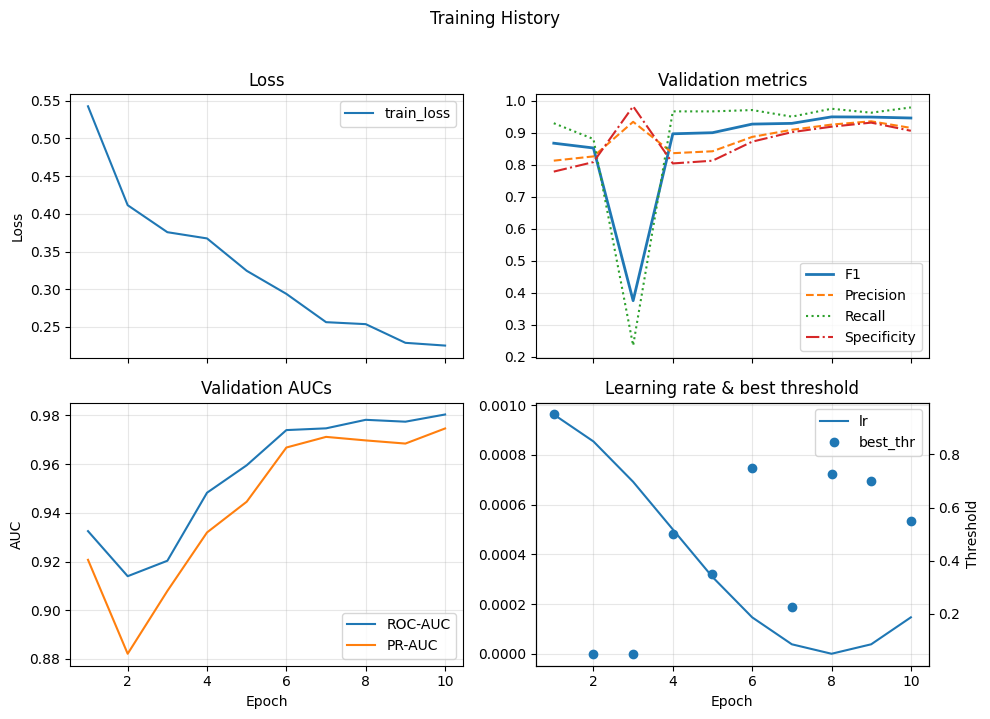

In [45]:
print_training_history(history_exp2)

In [46]:
save_training_history(history_exp2, file="training_history_exp2")

Saved training history to: E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\training_history_exp2.csv


In [ ]:
best_thr_exp2 = find_best_threshold_on_val(model_exp2, val_loader, device)

Best VAL threshold for F1: 0.557
F1: 0.948 | Precision: 0.919 | Recall: 0.979
Confusion matrix at best threshold [[TN, FP], [FN, TP]]:
[[214  21]
 [  5 238]]


In [74]:
test_metrics_exp2 = eval_with_threshold(model_exp2, test_loader, device, thr=best_thr_exp2)
print_eval_results(test_metrics_exp2, best_thr_exp2)

Test @ thr=0.557
  Acc:  0.943
  F1:   0.946
  Prec: 0.923
  Rec:  0.971
  Spec: 0.914
  ROC-AUC: 0.984 | PR-AUC: 0.983
  Confusion matrix [[TN, FP], [FN, TP]]:
[[265  25]
 [  9 298]]


----

#### Experiment 3: AdamW + ReduceLROnPlateau scheduler

In [47]:
# Instantiate a new model
model_exp3 = FedeNetTiny(in_ch=7).to(device)

In [48]:
optimizer_exp3 = optim.AdamW(
    model_exp3.parameters(),
    lr=2e-3,
    weight_decay=1e-4
)

In [49]:
scheduler_exp3 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_exp3,
    mode='max',               # since we monitor validation F1 (higher is better)
    factor=0.5,               # when no improvement, lr *= 0.5
    patience=2,               # wait 2 epochs then reduce
    threshold=1e-4,           # minimal improvement to count
    min_lr=1e-6,              # floor learning rate
    verbose=True
)

e:\Devs\pyEnv-1\venvs\FedeNet_test_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [53]:
# call training loop using optimizer_exp1 & scheduler_exp1
history_exp3 = train_model(
    model=model_exp3,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_exp3,
    scheduler=scheduler_exp3,
    criterion=criterion,
    scaler=scaler,
    epochs=10,
    checkpoint_dir=Path("checkpoints"),
    experiment_name="exp3",
    best_f1_init=-1.0
)

[Timing] data=0.1s  compute=128.9s
VAL @ thr=0.050 | Acc 0.874 | F1 0.889 | Prec 0.806 | Rec 0.992 | Spec 0.753 | ROC-AUC 0.947 | PR-AUC 0.921
Confusion matrix [[TN FP],[FN TP]]:
 [[177  58]
 [  2 241]]
New best model saved at epoch 1 (F1=0.889, thr=0.050)
[Epoch 01] train_loss=0.4015  val_f1=0.889  lr=2.00e-03  (317.3s)
[Timing] data=0.0s  compute=129.7s
VAL @ thr=0.950 | Acc 0.711 | F1 0.779 | Prec 0.638 | Rec 1.000 | Spec 0.413 | ROC-AUC 0.949 | PR-AUC 0.939
Confusion matrix [[TN FP],[FN TP]]:
 [[ 97 138]
 [  0 243]]
[Epoch 02] train_loss=0.3694  val_f1=0.779  lr=2.00e-03  (314.2s)
[Timing] data=0.1s  compute=128.9s
VAL @ thr=0.050 | Acc 0.822 | F1 0.800 | Prec 0.934 | Rec 0.700 | Spec 0.949 | ROC-AUC 0.946 | PR-AUC 0.936
Confusion matrix [[TN FP],[FN TP]]:
 [[223  12]
 [ 73 170]]
[Epoch 03] train_loss=0.3450  val_f1=0.800  lr=2.00e-03  (318.6s)
[Timing] data=0.0s  compute=129.1s
VAL @ thr=0.100 | Acc 0.921 | F1 0.923 | Prec 0.905 | Rec 0.942 | Spec 0.898 | ROC-AUC 0.971 | PR-AUC 0.

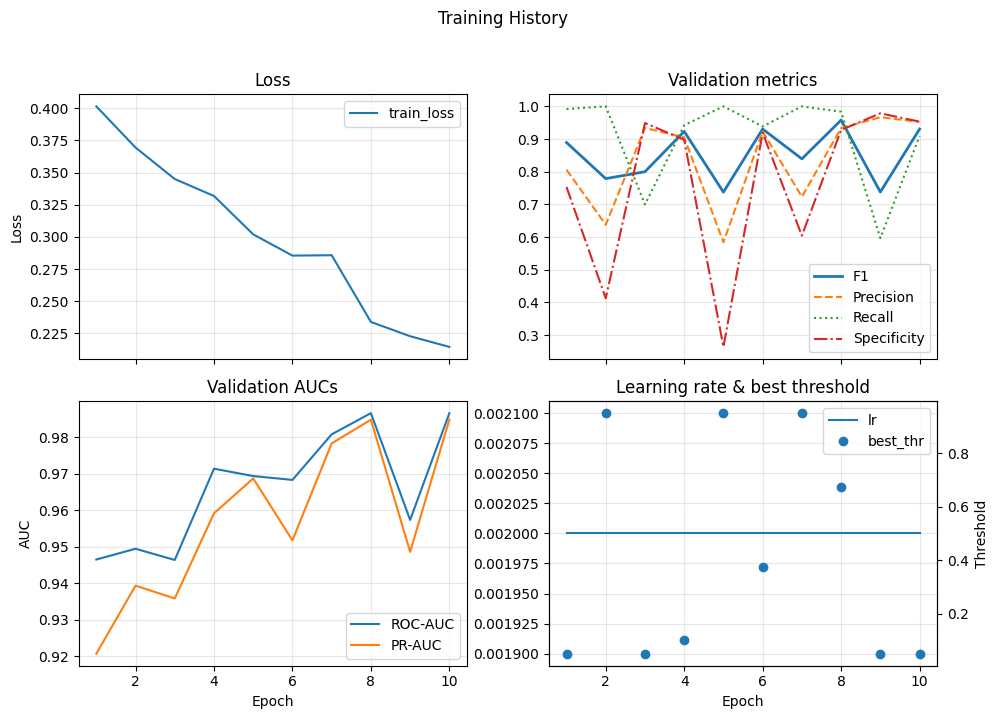

In [54]:
print_training_history(history_exp3)

In [55]:
save_training_history(history_exp3, file="training_history_exp3")

Saved training history to: E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\training_history_exp3.csv


In [ ]:
best_thr_exp3 = find_best_threshold_on_val(model_exp3, val_loader, device)

Best VAL threshold for F1: 0.005
F1: 0.951 | Precision: 0.910 | Recall: 0.996
Confusion matrix at best threshold [[TN, FP], [FN, TP]]:
[[211  24]
 [  1 242]]


In [71]:
test_metrics_exp3 = eval_with_threshold(model_exp3, test_loader, device, thr=best_thr_exp3)
print_eval_results(test_metrics_exp3, best_thr_exp3)

Test @ thr=0.005
  Acc:  0.945
  F1:   0.949
  Prec: 0.908
  Rec:  0.993
  Spec: 0.893
  ROC-AUC: 0.990 | PR-AUC: 0.991
  Confusion matrix [[TN, FP], [FN, TP]]:
[[259  31]
 [  2 305]]


----

#### Experiment 4: AdamW with Warmup + CosineAnnealingLR (Final FedeNet)

In [99]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

In [100]:
# Instantiate a new model
model_exp4 = FedeNetTiny(in_ch=7).to(device)

In [101]:
optimizer_exp4 = optim.AdamW(
    model_exp4.parameters(),
    lr=2e-3,
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

In [102]:
warmup_epochs = 1
total_epochs  = 20

sched_warmup  = LinearLR(optimizer_exp4, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs)
sched_cosine  = CosineAnnealingLR(optimizer_exp4, T_max=total_epochs - warmup_epochs, eta_min=2e-5)

scheduler_exp4 = SequentialLR(
    optimizer_exp4,
    schedulers=[sched_warmup, sched_cosine],
    milestones=[warmup_epochs],
    last_epoch=-1
)

In [103]:
# call training loop using optimizer_exp4
history_exp4 = train_model(
    model=model_exp4,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_exp4,
    scheduler=scheduler_exp4,
    criterion=criterion,
    scaler=scaler,
    epochs=10,
    checkpoint_dir=Path("checkpoints"),
    experiment_name="exp4",
    best_f1_init=-1.0
)

[Timing] data=0.1s  compute=128.0s
VAL @ thr=0.550 | Acc 0.856 | F1 0.863 | Prec 0.832 | Rec 0.897 | Spec 0.813 | ROC-AUC 0.920 | PR-AUC 0.911
Confusion matrix [[TN FP],[FN TP]]:
 [[191  44]
 [ 25 218]]
New best model saved at epoch 1 (F1=0.863, thr=0.550)
[Epoch 01] train_loss=0.6740  val_f1=0.863  lr=2.00e-03  (324.2s)


e:\Devs\pyEnv-1\venvs\FedeNet_test_env\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Timing] data=0.1s  compute=128.3s
VAL @ thr=0.050 | Acc 0.837 | F1 0.846 | Prec 0.814 | Rec 0.881 | Spec 0.791 | ROC-AUC 0.914 | PR-AUC 0.891
Confusion matrix [[TN FP],[FN TP]]:
 [[186  49]
 [ 29 214]]
[Epoch 02] train_loss=0.4491  val_f1=0.846  lr=1.99e-03  (328.0s)
[Timing] data=0.1s  compute=128.6s
VAL @ thr=0.825 | Acc 0.879 | F1 0.881 | Prec 0.878 | Rec 0.885 | Spec 0.872 | ROC-AUC 0.936 | PR-AUC 0.905
Confusion matrix [[TN FP],[FN TP]]:
 [[205  30]
 [ 28 215]]
New best model saved at epoch 3 (F1=0.881, thr=0.825)
[Epoch 03] train_loss=0.3822  val_f1=0.881  lr=1.95e-03  (331.2s)
[Timing] data=0.0s  compute=130.3s
VAL @ thr=0.950 | Acc 0.831 | F1 0.854 | Prec 0.761 | Rec 0.971 | Spec 0.685 | ROC-AUC 0.944 | PR-AUC 0.935
Confusion matrix [[TN FP],[FN TP]]:
 [[161  74]
 [  7 236]]
[Epoch 04] train_loss=0.3793  val_f1=0.854  lr=1.88e-03  (326.4s)
[Timing] data=0.1s  compute=128.9s
VAL @ thr=0.250 | Acc 0.908 | F1 0.913 | Prec 0.875 | Rec 0.955 | Spec 0.860 | ROC-AUC 0.964 | PR-AUC 0.

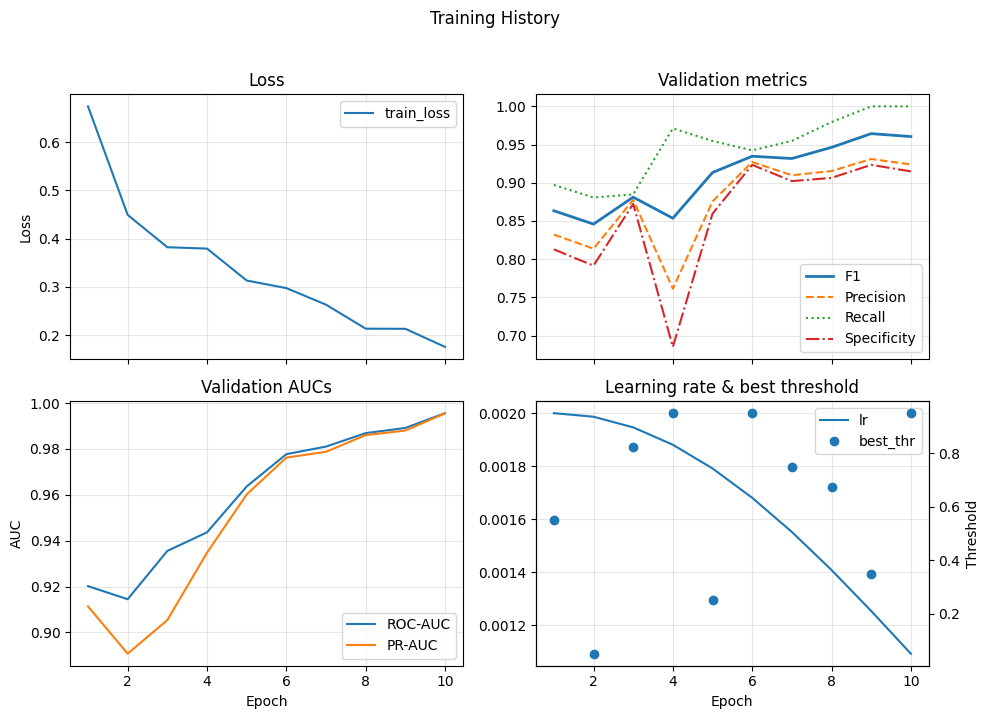

In [104]:
print_training_history(history_exp4)

In [113]:
save_training_history(history_exp4, file="training_history_exp4_warmup_cosine20")

Saved training history to: E:\Devs\pyEnv-1\Apziva\MonReader\checkpoints\training_history_exp4_warmup_cosine20.csv


In [111]:
best_thr_exp4 = find_best_threshold_on_val(model_exp4, val_loader, device)

Best VAL threshold for F1: 0.979
F1: 0.980 | Precision: 0.960 | Recall: 1.000
Confusion matrix at best threshold [[TN, FP], [FN, TP]]:
[[225  10]
 [  0 243]]


In [112]:
test_metrics_exp4 = eval_with_threshold(model_exp4, test_loader, device, thr=best_thr_exp4)
print_eval_results(test_metrics_exp4, best_thr_exp4)

Test @ thr=0.979
  Acc:  0.963
  F1:   0.965
  Prec: 0.952
  Rec:  0.977
  Spec: 0.948
  ROC-AUC: 0.995 | PR-AUC: 0.995
  Confusion matrix [[TN, FP], [FN, TP]]:
[[275  15]
 [  7 300]]


In [114]:
# Save final model
torch.save(model_exp4.state_dict(), Path("checkpoints") / "fedenet_v4_warmcos20_best.pth")

### Conclusion

**FedeNET-v4 (AdamW + 1-epoch warmup → Cosine, 20 epochs)** delivers **F1 = 0.965**, **ROC-AUC = 0.995**, and **PR-AUC = 0.995** on the test set (Precision = 0.952, Recall = 0.977, Specificity = 0.948).  
This confirms that **explicit frequency cues at the input level (Sobel, Laplacian, LocalVar, High-Pass)** are highly informative for the “flip vs not-flip” task, even with a compact backbone. The model achieves **near-ceiling AUCs** while remaining efficient and lightweight.

#### Comparison with larger CNNs

| Model (fine-tuned) | Params | F1-Score | ROC-AUC | PR-AUC |
|--------------------|--------:|---------:|---------:|--------:|
| **ResNet18** | 11.7 M | **0.994** | **0.999** | **0.999** |
| **EfficientNet-B0** | 5.3 M | 0.984 | 0.996 | 0.995 |
| **MobileNet-V2** | 3.5 M | 0.942 | 0.982 | 0.980 |
| **FedeNET** | *tiny: 24 K* | 0.965 | 0.995 | 0.995 |

#### Key Observations

- **Accuracy ceiling:** Full ImageNet backbones such as **ResNet18** still set the upper bound (F1 ≈ 0.994).  
  If absolute accuracy is critical and inference cost is secondary, ResNet18 remains the best choice.

- **Efficiency and specialization:** **FedeNET-v4** reaches **EfficientNet-B0–level AUCs** with a **fraction of the parameters**, and clearly outperforms **MobileNet-V2** on this task.  
  This makes FedeNET-v4 highly attractive for on-device or high-throughput scenarios.

- **Interpretability:**  
  FedeNET’s fixed frequency channels make the model more interpretable by directly exposing blur and edge energy differences, which are central to the “flip vs not-flip” problem.

#### When to Choose Which Model

- **Maximum accuracy (no latency/memory limits):** ResNet18  
- **Balanced accuracy and efficiency:** EfficientNet-B0 or **FedeNET**  
- **Strict efficiency or edge deployment:** **FedeNET** task-specific, compact, and interpretable

---

#### Final Remarks

**FedeNET** demonstrates that a **task-aware, frequency-enhanced CNN** can achieve **near state-of-the-art AUCs** and **strong F1-scores** while using only a **fraction of the parameters** required by conventional deep backbones.  
With minor post-hoc calibration or knowledge distillation, it can serve as a **highly efficient, interpretable, and deployable model**, ideally suited for **real-world applications under limited computing infrastructures**.

---